# PaperDoll raw dataset usage

The following demonstrates how to use PaperDoll raw dataset in Python.

In [1]:
import io
import lmdb
import sqlite3
import pandas as pd
from PIL import Image
from IPython.display import display

## Photos metadata

Photo URL is "http://images{N}.chictopia.com" + path, where N is one of {0, 1, 2, 3}. Can be any.
For example, either of the following works.

    http://images1.chictopia.com/photos/thefashbot/1930972049/1930972049_400.jpg
    http://images2.chictopia.com/photos/thefashbot/1930972049/1930972049_400.jpg

In [2]:
db = sqlite3.connect('file:chictopia.sqlite3?mode=ro', uri=True)

photos = pd.read_sql("""
    SELECT
        *,
        'http://images2.chictopia.com/' || path AS url
    FROM photos
    WHERE photos.post_id IS NOT NULL AND file_file_size IS NOT NULL
""", con=db)
print('photos = %d' % (len(photos)))
photos.head()

photos = 1100987


,id,post_id,path,status,file_file_name,file_file_size,file_content_type,file_updated_at,width,height,created_at,updated_at,url
0,1,61,/photos/thefashbot/1930972049/1930972049_400.jpg,2,open-uri20120907-29328-3yd0mp,122564,image/jpeg,2012-09-07 23:07:38.719079,400,600,2012-09-07 23:07:38.441357,2012-09-07 23:07:39.456904,http://images2.chictopia.com//photos/thefashbo...
1,2,73,/photos/thefashbot/3613535083/3613535083_400.jpg,2,open-uri20120907-29328-1szdum6,119821,image/jpeg,2012-09-07 23:07:45.966209,400,600,2012-09-07 23:07:45.721208,2012-09-07 23:07:46.438801,http://images2.chictopia.com//photos/thefashbo...
2,3,73,/photos/thefashbot/3613535083/3420751783/34207...,2,open-uri20120907-29328-1uz77bi,115073,image/jpeg,2012-09-07 23:07:46.825511,400,600,2012-09-07 23:07:45.785651,2012-09-07 23:07:47.722063,http://images2.chictopia.com//photos/thefashbo...
3,4,85,/photos/thefashbot/10902372197/10902372197_400...,2,open-uri20120907-29328-1nqep2j,115259,image/jpeg,2012-09-07 23:07:53.314908,400,600,2012-09-07 23:07:52.920956,2012-09-07 23:07:54.329817,http://images2.chictopia.com//photos/thefashbo...
4,5,98,/photos/thefashbot/4328323416/4328323416_400.jpg,2,open-uri20120907-29328-10ax6ou,123235,image/jpeg,2012-09-07 23:08:00.645646,400,600,2012-09-07 23:08:00.081276,2012-09-07 23:08:01.889023,http://images2.chictopia.com//photos/thefashbo...


## Photo data in LMDB

The following is a convenient wrapper over LMDB.

In [3]:
class PhotoData(object):
    def __init__(self, path):
        self.env = lmdb.open(
            path, map_size=2**36, readonly=True, lock=False
        )
        
    def __iter__(self):
        with self.env.begin() as t:
            with t.cursor() as c:
                for key, value in c:
                    yield key, value
        
    def __getitem__(self, index):
        key = str(index).encode('ascii')
        with self.env.begin() as t:
            data = t.get(key)
        if not data:
            return None
        with io.BytesIO(data) as f:
            image = Image.open(f)
            image.load()
            return image
        
    def __len__(self):
        return self.env.stat()['entries']

In [4]:
photo_data = PhotoData('./photos.lmdb')
print(len(photo_data))

1097474


1
http://images2.chictopia.com//photos/thefashbot/1930972049/1930972049_400.jpg


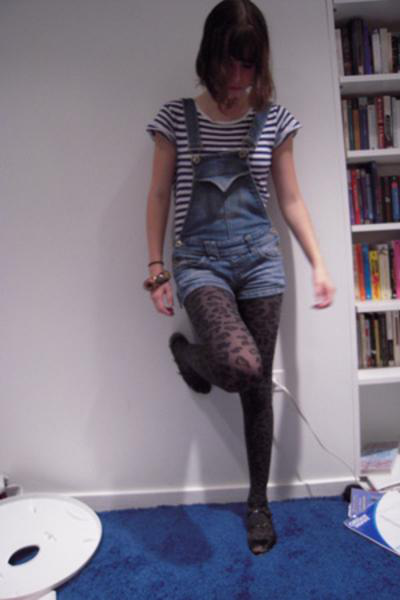

2
http://images2.chictopia.com//photos/thefashbot/3613535083/3613535083_400.jpg


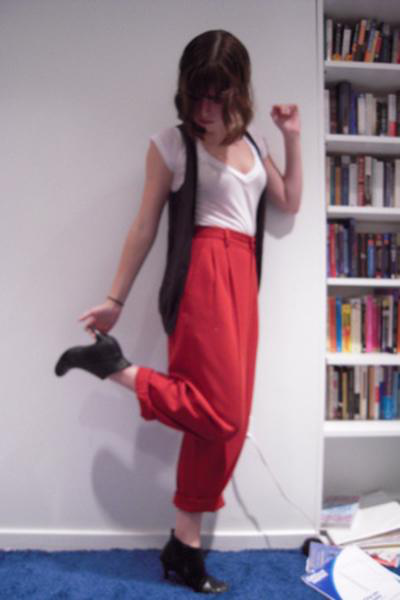

3
http://images2.chictopia.com//photos/thefashbot/3613535083/3420751783/3420751783_400.jpg


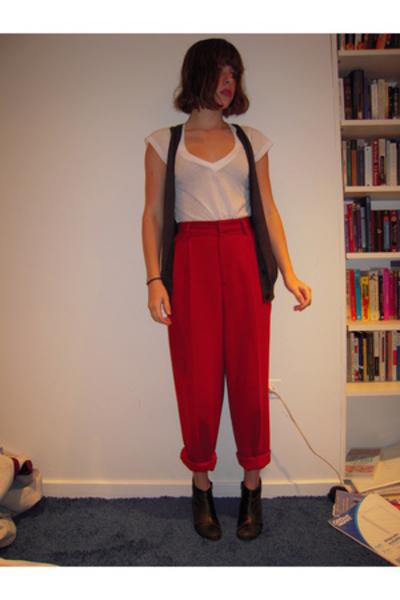

4
http://images2.chictopia.com//photos/thefashbot/10902372197/10902372197_400.jpg


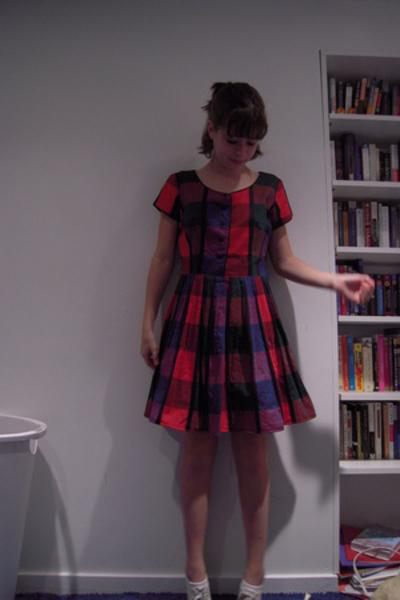

5
http://images2.chictopia.com//photos/thefashbot/4328323416/4328323416_400.jpg


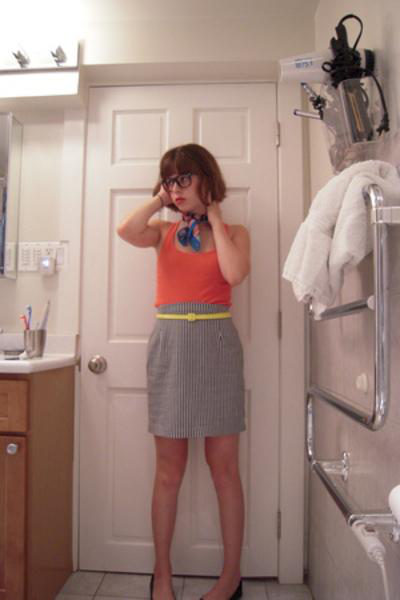

6
http://images2.chictopia.com//photos/thefashbot/3846669952/3846669952_400.jpg


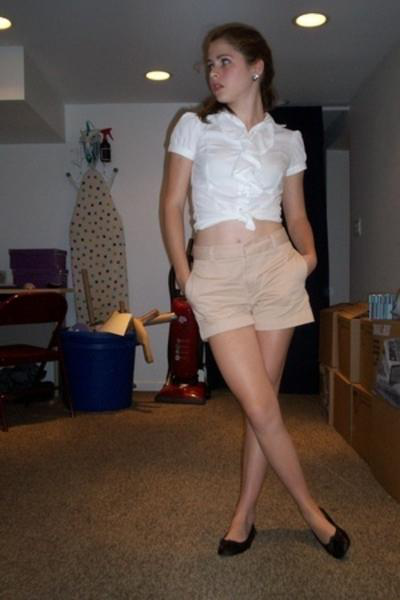

7
http://images2.chictopia.com//photos/thefashbot/3846669952/9248053763/9248053763_400.jpg


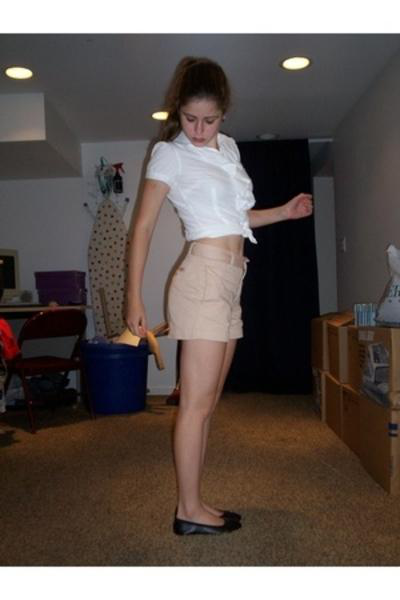

8
http://images2.chictopia.com//photos/thefashbot/5904281257/5904281257_400.jpg


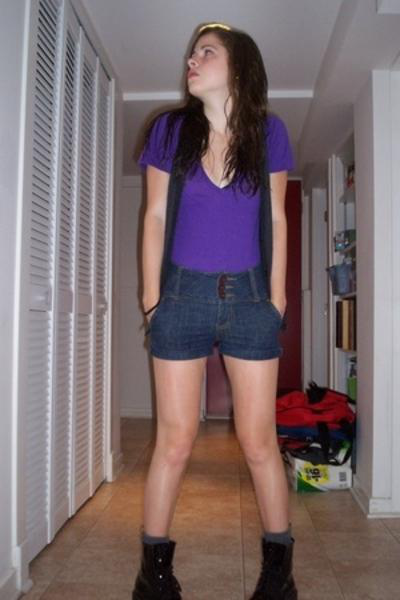

9
http://images2.chictopia.com//photos/thefashbot/5904281257/6406208724/6406208724_400.jpg


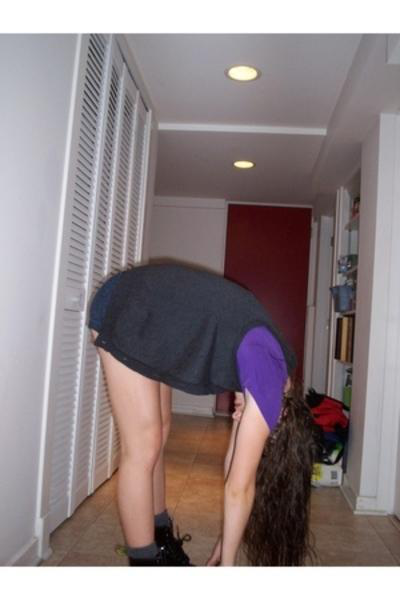

10
http://images2.chictopia.com//photos/homme/5747766283/5747766283_400.jpg


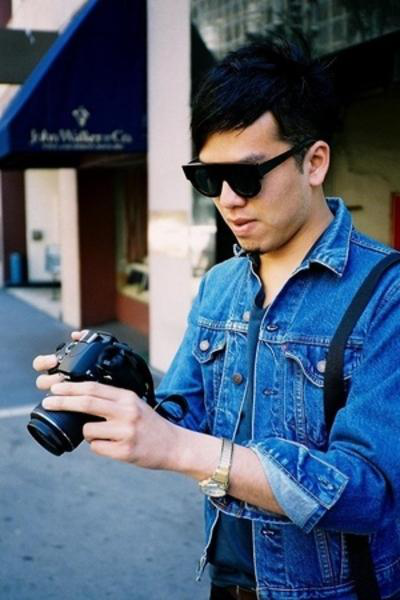

In [6]:
for i in range(10):
    photo = photos.iloc[i]
    print(photo.id)
    print(photo.url)
    display(photo_data[photo.id])